In [1]:
# general
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import cv2

# torch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data import random_split

### Structure
- plot images
- text preprocessing
- data loader
- image augmentation

### Plot images

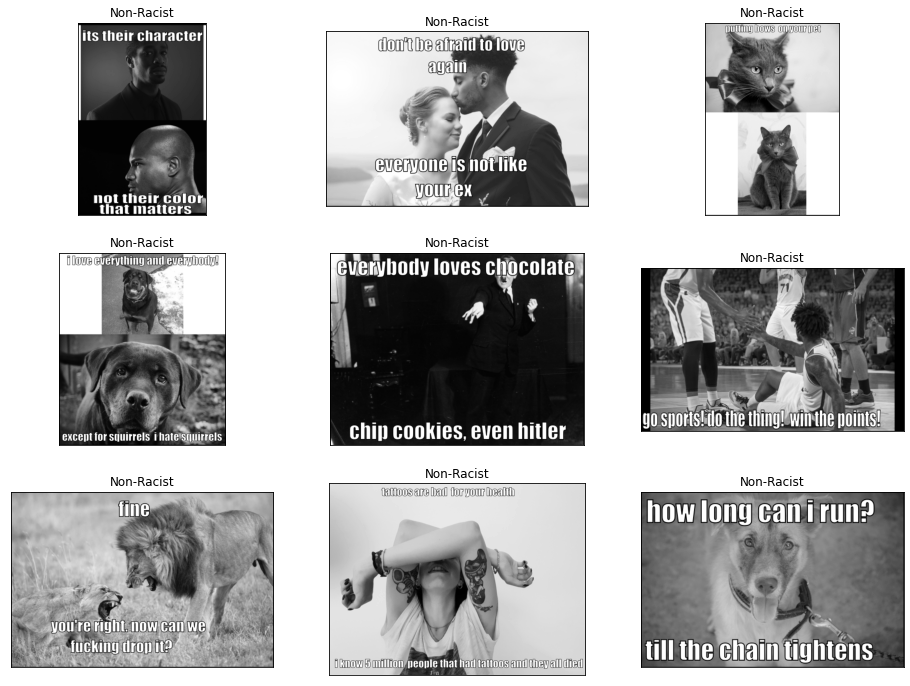

In [2]:
dataset_df = pd.read_json('../data/train.jsonl', lines=True)

# plot a few images together with labels
nx = 3
ny = 3

fig, ax = plt.subplots(figsize=(16, ny*4), nrows=ny, ncols=nx)
for i in range(ny):
    for j in range(nx):
        img_id = dataset_df['id'].values[i*nx+ j]
        
        # catch trailing 0
        if img_id < 1e4:
            img = cv2.imread('../data/img/0'+str(img_id)+ '.png', cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread('../data/img/'+str(img_id)+ '.png', cv2.IMREAD_GRAYSCALE)  
        
        # plot and remove axes
        ax[i,j].imshow(img, cmap='gray')
        ax[i,j].set_title('Racist' if dataset_df['label'].values[i*nx+ j] else 'Non-Racist')
        ax[i,j].axes.get_xaxis().set_visible(False)
        ax[i,j].axes.get_yaxis().set_visible(False)
        
plt.show()

### Text Preprocessing

Bert requires: <br>
- tokenization
- special characters
- padding
- mask

techniques to try (for other models): <br>
- Lower casing
- Punctuation removal
- Stopwords removal
- Frequent words removal
- Rare words removal
- Spelling correction
- Tokenization
- Stemming
- Lemmatization
- word embedding/ bag of words

In [3]:
path_text = '../data/train.jsonl'

# read text
dataset_df = pd.read_json(path_text, lines=True)
dataset_df.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [4]:
# dictionary
data = dataset_df.to_dict(orient='records') # have been shuffled in previous step

# Calculate the number of samples to include in each set.
train_size = int(0.01 * len(data))
val_size = len(data) - train_size

# train valid split
train_data, valid_data = random_split(data, [train_size, val_size])

train_size = int(0.05 * len(valid_data))
val_size = len(valid_data) - train_size
valid_data, _ = random_split(valid_data, [train_size, val_size])

In [5]:
# split into text (input) and labels (output)
train_texts, train_imgs, train_labels = list(zip(*map(lambda d: (d['text'], d['img'], d['label']), train_data)))
valid_texts, valid_imgs, valid_labels = list(zip(*map(lambda d: (d['text'], d['img'], d['label']), valid_data)))

len(train_texts), len(train_labels), len(valid_texts), len(valid_labels)

(85, 85, 420, 420)

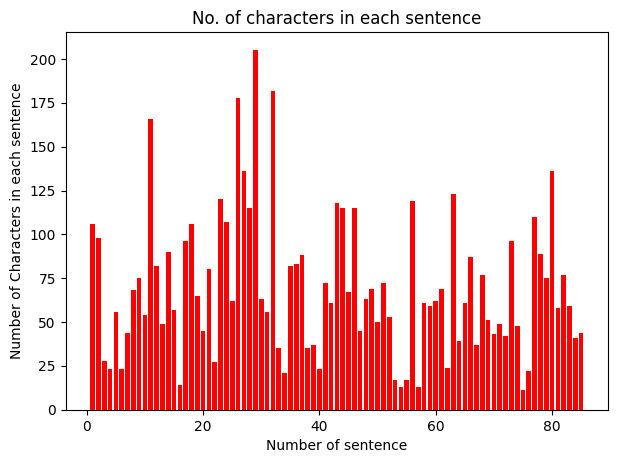

In [6]:
# analysis of review length
sentences = [len(sent) for sent in train_texts]
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1,len(train_texts)+1), sentences, color = ['red'])
plt.gca().set(title='No. of characters in each sentence', xlabel='Number of sentence', ylabel='Number of Characters in each sentence');

# -> bert with 64 tokens should be sufficient

In [7]:
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences

# bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

Using TensorFlow backend.


In [8]:
# token embeddings with required separation token
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:62] + ['[SEP]'], train_texts))
valid_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:62] + ['[SEP]'], valid_texts))

len(train_tokens), len(valid_tokens)

(85, 420)

In [9]:
# prepare token ids: each token (word fragment) corresponds to an id in the bert corpus
# further need to make all review the same length -> padding too short, truncating too long ones
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=64, truncating="post", padding="post", dtype="int")
valid_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, valid_tokens)), maxlen=64, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, valid_tokens_ids.shape

((85, 64), (420, 64))

In [10]:
# mask for padding -> required by bert
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
valid_masks = [[float(i > 0) for i in ii] for ii in valid_tokens_ids]

In [11]:
# put everything back into a dictionary
data_train = {'img_names': train_imgs, 'tokens': train_tokens, 'token_ids': train_tokens_ids,
              'masks': train_masks, 'labels': train_labels}

data_valid = {'img_names': valid_imgs, 'tokens': valid_tokens, 'token_ids': valid_tokens_ids,
              'masks': valid_masks, 'labels': valid_labels}

## Dataloader

In [12]:
class HatefulMemesDataset(Dataset):
    """ Hateful Memes dataset """
    
    def __init__(self, data, img_dir, normalize=False, transform=None):
        """
        Args:
            df_path (string): path to jsonl file with image id's
            root_dir (string): directory with all the images
            transform (callable): optional transform to be applied on a sample
        """
        # text
        self.data = data
        
        # image
        self.img_dir = img_dir
        self.normalize = normalize
        self.transform = transform
        
    def __len__(self):
        return len(self.data['labels'])
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx_tolist()
            
            
        data_train = {'img_names': train_imgs, 'tokens': train_tokens, 'token_ids': train_tokens_ids,
              'masks': train_masks, 'labels': train_labels}
        
        # load image
        img_name = os.path.join(self.img_dir, str(self.data['img_names'][idx]))
        image = cv2.imread(img_name)
        #image = image.astype(np.float)
        
        if self.normalize:
            # TODO: normalize image by mean and std -> what data type do networks require?
            print('TODO')
        
        # token
        token = self.data['tokens'][idx]
        token_id = self.data['token_ids'][idx]
        
        # label
        label = self.data['labels'][idx]
        label = np.array([label])
        label = label.astype('int').reshape(-1)
        
        # mask
        mask = self.data['masks'][idx]
        mask = np.array([mask])
        mask = mask.astype('float').reshape(-1)
        
        #
        sample = {'image': image, 'token_id': token_id, 'mask': mask, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

0 (606, 800, 3) (1,)
1 (366, 550, 3) (1,)
2 (366, 550, 3) (1,)
3 (400, 392, 3) (1,)


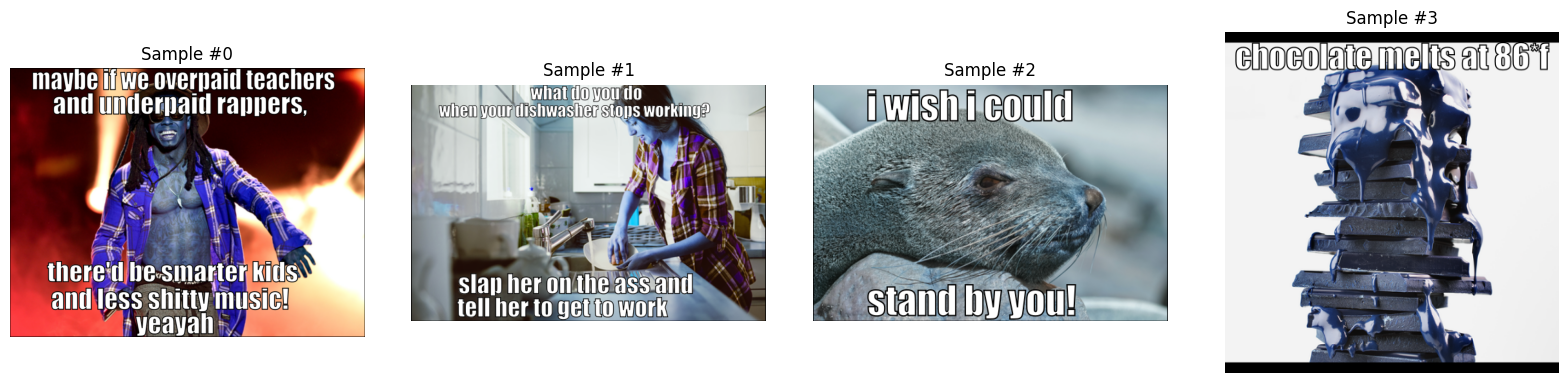

In [13]:
memes_dataset = HatefulMemesDataset(data_train, img_dir='../data', normalize=False)

fig = plt.figure(figsize=(16, 4))

for i in range(len(memes_dataset)):
    sample = memes_dataset[i]

    print(i, sample['image'].shape, sample['label'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    #ax.set_xlabel(sample['text'])
    #print(sample['token'])
    ax.axis('off')
    
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

## Image augmentation

In [14]:
# aspect ratio = 1.3 (width / height) median
# image dimensions = 128 x 128 (16k pixels) for CNN's

class Rescale(object):
    """Rescale the image in a sample to a given size
    Args:
        img_width (int): desired width of image
        max_distortion (float): maximum distortion of an image in a given direction
    """
    
    def __init__(self, size, max_distortion):
        self.size = size
        self.max_distortion = max_distortion
        
    def __call__(self, sample):
        image, token_id, mask, label = sample['image'], sample['token_id'], sample['mask'], sample['label']

        #
        width, height = image.shape[:2]
        aspect_ratio = width/ height
        
        # resulting distortion too high -> padding
        if aspect_ratio > self.max_distortion:
            pad = width- 2*height
            img = cv2.copyMakeBorder(image, int(pad/2.), int(pad/2.), 0, 0, cv2.BORDER_CONSTANT)
        elif 1./aspect_ratio > self.max_distortion:
            pad = height- 2*width
            img = cv2.copyMakeBorder(image, 0, 0, int(pad/2.), int(pad/2.), cv2.BORDER_CONSTANT)
        else:
            img = image.copy()
            
        # resize image
        #img = img.astype(np.float)
        img = transform.resize(img, (self.size, self.size))
        
        return {'image': img, 'token_id': token_id, 'mask': mask, 'label': label}

In [15]:
# cropping, scaling, rotation, noise, color?
class Transform(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self):
        pass
        
    def __call__(self, sample):
        image, token_id, mask, label = sample['image'], sample['token_id'], sample['mask'], sample['label']
        
        transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.RandomRotation(degrees=(-20, 20))])
        
        # TODO: these lines needed?
        img = (255.* image).astype(np.uint8)
        img = transform(img.astype(np.uint8))
        
        
        # TODO: use normalization as required by pretrained models
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
        
        
        return {'image': img,'token_id': token_id, 'mask': mask, 'label': label}

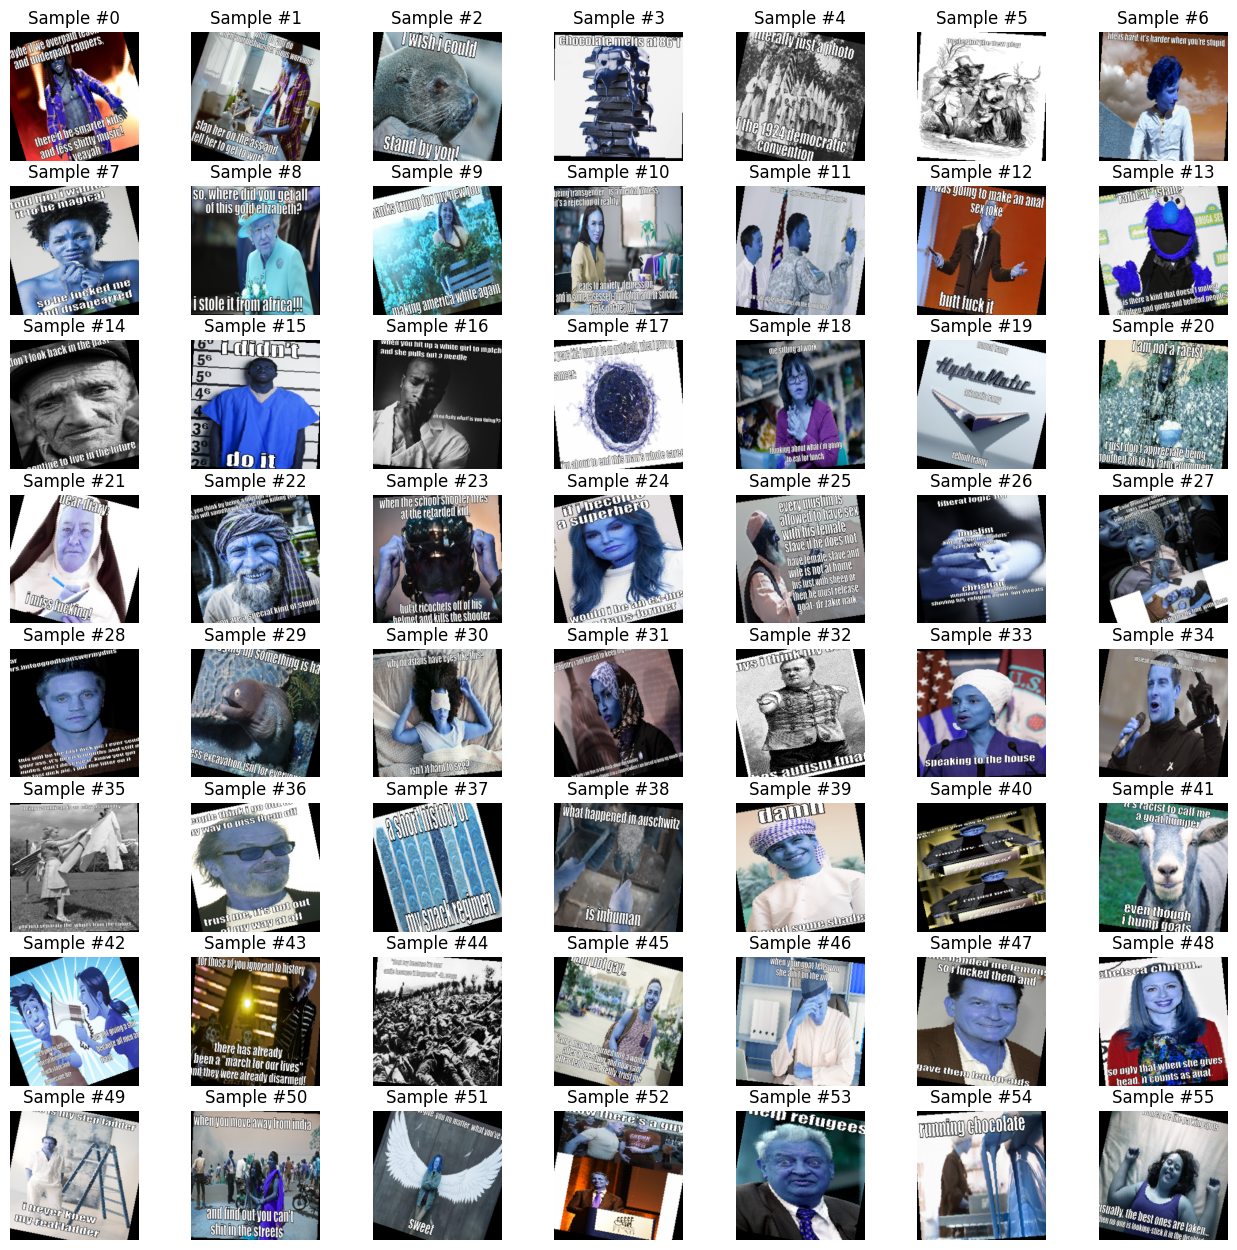

In [16]:
# dataset
composed = transforms.Compose([Rescale(224, 2.),
                               Transform()])

memes_dataset = HatefulMemesDataset(data_train, img_dir='../data',
                                    normalize=False, transform=composed)

#plota
ncols = 7
nrows = 8
fig, ax = plt.subplots(figsize=(16, 16), ncols=ncols, nrows=nrows)

for i in range(ncols*nrows):
    x = i%ncols 
    y = int(i/ncols)
    
    sample = memes_dataset[i]

    ax[y,x].imshow(sample['image'])
    ax[y,x].set_title('Sample #{}'.format(i))
    ax[y,x].axis('off')

plt.show()

## Model 

In [17]:
import torch.nn as nn
import torchvision.models as models
from pytorch_pretrained_bert import BertModel
import torch.nn.functional as F

# bert model class
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, imgs, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba


In [18]:
# https://discuss.pytorch.org/t/combining-trained-models-in-pytorch/28383/2
class MyEnsemble(nn.Module):
    def __init__(self):
        super(MyEnsemble, self).__init__()
        # pretrained models
        self.modelVision = models.densenet161(pretrained=True)
        self.modelNLP = BertModel.from_pretrained('bert-base-cased')
        
        # give densenet an untrained classifier layer
        self.modelVision.classifier = nn.Linear(2208, 1000)
        
        # classifier layer
        self.classifier1 = nn.Linear(768+ 1000, 1000)
        self.classifier2 = nn.Linear(1000, 1)
        
    def forward(self, imgs, tokens, masks):
        # vision
        x1 = self.modelVision(imgs)
        
        # Bert is such that the first token contains all info for classification
        _, x2 = self.modelNLP(tokens, attention_mask=masks, output_all_encoded_layers=False)
        
        # TODO: dropout needed?
        x = torch.cat((x1, x2), dim=1)
        x = F.relu(self.classifier1(x))
        y = F.sigmoid(self.classifier2(x))
        
        return y

In [19]:
# allocate on gpu
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

model = MyEnsemble().to(device)
print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')

557.574144M


In [20]:
from torch.optim import Adam
# TODO: not sure if this does what I think it should do
# optimizer
param_optimizer = list(model.modelVision.classifier.named_parameters())
param_optimizer += list(model.classifier1.named_parameters())
param_optimizer += list(model.classifier2.named_parameters())
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = Adam(optimizer_grouped_parameters, lr=3e-6) # TODO: SGD for just the final classifier

In [21]:
print([p[1].size() for p in param_optimizer])

[torch.Size([1000, 2208]), torch.Size([1000]), torch.Size([1000, 1768]), torch.Size([1000]), torch.Size([1, 1000]), torch.Size([1])]


In [22]:
densenet = models.densenet161(pretrained=True)
for name, child in densenet.named_children():
    print(name)
    for param in child.parameters():
            print(param.shape)

features
torch.Size([96, 3, 7, 7])
torch.Size([96])
torch.Size([96])
torch.Size([96])
torch.Size([96])
torch.Size([192, 96, 1, 1])
torch.Size([192])
torch.Size([192])
torch.Size([48, 192, 3, 3])
torch.Size([144])
torch.Size([144])
torch.Size([192, 144, 1, 1])
torch.Size([192])
torch.Size([192])
torch.Size([48, 192, 3, 3])
torch.Size([192])
torch.Size([192])
torch.Size([192, 192, 1, 1])
torch.Size([192])
torch.Size([192])
torch.Size([48, 192, 3, 3])
torch.Size([240])
torch.Size([240])
torch.Size([192, 240, 1, 1])
torch.Size([192])
torch.Size([192])
torch.Size([48, 192, 3, 3])
torch.Size([288])
torch.Size([288])
torch.Size([192, 288, 1, 1])
torch.Size([192])
torch.Size([192])
torch.Size([48, 192, 3, 3])
torch.Size([336])
torch.Size([336])
torch.Size([192, 336, 1, 1])
torch.Size([192])
torch.Size([192])
torch.Size([48, 192, 3, 3])
torch.Size([384])
torch.Size([384])
torch.Size([192, 384, 1, 1])
torch.Size([192])
torch.Size([192])
torch.Size([192, 192, 1, 1])
torch.Size([192])
torch.Size([

In [23]:
bert = BertModel.from_pretrained('bert-base-uncased')
for name, child in bert.named_children():
    print(name)
    for param in child.parameters():
            print(param.shape)

embeddings
torch.Size([30522, 768])
torch.Size([512, 768])
torch.Size([2, 768])
torch.Size([768])
torch.Size([768])
encoder
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([3072, 768])
torch.Size([3072])
torch.Size([768, 3072])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([3072, 768])
torch.Size([3072])
torch.Size([768, 3072])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768, 768])
torch.Size([768])
torch.Size([768])
torch.Size([768])
torch.Size([3072, 768])
torch.Size

## Training

In [24]:
from torch.nn.utils import clip_grad_norm_

# training
torch.cuda.empty_cache()   # Clearing Cache space for a fresh Model run

EPOCHS=15
BATCH_SIZE=2

# training
train_dataset = HatefulMemesDataset(data_train, img_dir='../data',
                                    normalize=False, transform=Rescale(224, 2.)) # TODO: I somehwere read that image models need 224x224 input
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# validation
valid_dataset = HatefulMemesDataset(data_valid, img_dir='../data',
                                    normalize=False, transform=Rescale(224, 2.)) # TODO: I somehwere read that image models need 224x224 input
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

# monitor train progress
stats = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': []}

for epoch_num in range(EPOCHS):
    model.train()
    train_loss = 0.
    train_correct = 0.
    
    valid_loss = 0.
    valid_correct = 0.
    
    # training
    model.train()
    
    for step_num, batch in enumerate(train_loader):
        
        # sample = {'image': image, 'token_id': token_id, 'mask': mask, 'label': label}        
        imgs = batch['image'].to(device)
        imgs = imgs.view(-1, 3, 224, 224)
        
        labels = batch['label'].to(device)
        masks = batch['mask'].to(device)
        token_ids = batch['token_id'].to(device)
        # imgs, token_ids, masks, labels = tuple(t.to(device) for t in batch)
        # print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        
        logits = model(imgs.float(), token_ids, masks)
        
        # binary cross entropy loss (classification)
        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels.float())
        train_loss += batch_loss.item()
        
        train_correct += sum(torch.round(logits)==labels).item()
        
        # reset gradient and calculate new ones
        model.zero_grad()
        batch_loss.backward()
        
        # gradient clipping and backward pass
        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # logging
        # clear_output(wait=True) -> from IPython.display import clear_output
        if step_num%100==0:
            print('Epoch: ', epoch_num + 1)
            print("\r" + "{0}/{1} loss: {2} acc: {3} ".format(step_num,
                                                              len(train_data) / BATCH_SIZE,
                                                              round(train_loss / (step_num + 1), 3),
                                                              round(train_correct/ ((step_num+1)* BATCH_SIZE), 3)))
        
    # train stats
    stats['train_loss'].append(train_loss / ((step_num+1)* BATCH_SIZE))
    stats['train_acc'].append(train_correct / ((step_num+1)* BATCH_SIZE))
    
    # switch to optimize for all paramters 
    optimizer = Adam(model.parameters(), lr=3e-6)
        
    # validation
    model.eval()

    for step_num, batch in enumerate(valid_loader):
        # sample = {'image': image, 'token_id': token_id, 'mask': mask, 'label': label}        
        imgs = batch['image'].to(device)
        imgs = imgs.view(-1, 3, 224, 224)

        labels = batch['label'].to(device)
        masks = batch['mask'].to(device)
        token_ids = batch['token_id'].to(device)

        logits = model(imgs.float(), token_ids, masks)

        # binary cross entropy loss (classification)
        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels.float())
        valid_loss += batch_loss.item()

        valid_correct += sum(torch.round(logits)==labels).item()

    # logging
    # clear_output(wait=True) -> from IPython.display import clear_output
    print('Epoch: ', epoch_num + 1)
    print("\r" + "Validation loss: {0} acc: {1} ".format(round(valid_loss / ((step_num+1)* BATCH_SIZE), 3),
                                                         round(valid_correct/ ((step_num+1)* BATCH_SIZE), 3)))

    # valid stats
    stats['valid_loss'].append(valid_loss / ((step_num+1)* BATCH_SIZE))
    stats['valid_acc'].append(valid_correct / ((step_num+1)* BATCH_SIZE))

/home/roman/torch/lib/python3.6/site-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch:  1
0/42.5 loss: 0.708 acc: 0.5 
Epoch:  1
Validation loss: 0.336 acc: 0.638 
Epoch:  2
0/42.5 loss: 0.792 acc: 0.0 
Epoch:  2
Validation loss: 0.335 acc: 0.638 
Epoch:  3
0/42.5 loss: 0.6 acc: 1.0 
Epoch:  3
Validation loss: 0.332 acc: 0.638 
Epoch:  4
0/42.5 loss: 0.701 acc: 0.5 
Epoch:  4
Validation loss: 0.328 acc: 0.66 
Epoch:  5
0/42.5 loss: 0.705 acc: 0.5 
Epoch:  5
Validation loss: 0.326 acc: 0.624 
Epoch:  6
0/42.5 loss: 0.514 acc: 1.0 
Epoch:  6
Validation loss: 0.317 acc: 0.645 
Epoch:  7
0/42.5 loss: 0.325 acc: 1.0 
Epoch:  7
Validation loss: 0.344 acc: 0.619 
Epoch:  8
0/42.5 loss: 0.159 acc: 1.0 
Epoch:  8
Validation loss: 0.4 acc: 0.66 
Epoch:  9
0/42.5 loss: 0.107 acc: 1.0 
Epoch:  9
Validation loss: 0.493 acc: 0.679 
Epoch:  10
0/42.5 loss: 0.055 acc: 1.0 
Epoch:  10
Validation loss: 0.63 acc: 0.64 
Epoch:  11
0/42.5 loss: 0.033 acc: 1.0 
Epoch:  11
Validation loss: 0.765 acc: 0.605 
Epoch:  12
0/42.5 loss: 0.016 acc: 1.0 
Epoch:  12
Validation loss: 0.894 acc: 0

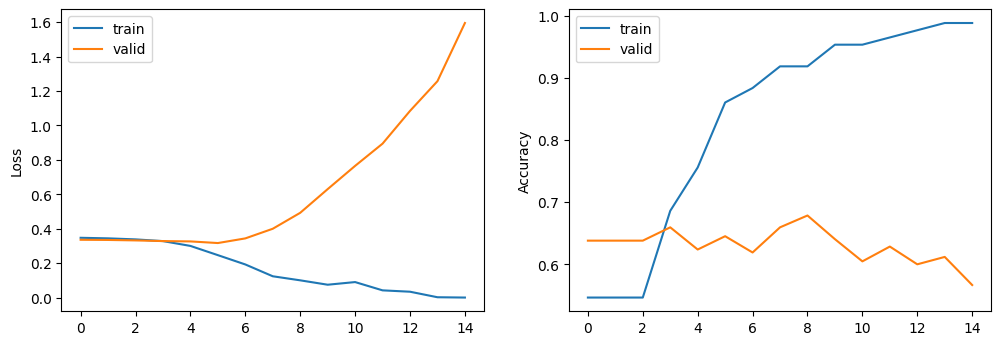

In [25]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
ax[0].plot(stats['train_loss'])
ax[0].plot(stats['valid_loss'])
ax[0].legend(['train', 'valid'])
ax[0].set_ylabel('Loss')

ax[1].plot(stats['train_acc'])
ax[1].plot(stats['valid_acc'])
ax[1].legend(['train', 'valid'])
ax[1].set_ylabel('Accuracy')
plt.show()

## Predictions

In [26]:
# test data for competition
path_test = '../data/test.jsonl'

# read text
dataset_test = pd.read_json(path_test, lines=True)

# dictionary
data_test = dataset_test.to_dict(orient='records') # have been shuffled in previous step

# split into text (input) and labels (output)
test_texts, test_imgs, test_ids = list(zip(*map(lambda d: (d['text'], d['img'], d['id']), data_test)))
test_labels = np.zeros(len(test_ids)) # TODO: hack to use current implementation of Dataset class

print(len(test_texts))

# token embeddings with required separation token
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:62] + ['[SEP]'], test_texts))

# prepare token ids
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=64, truncating="post", padding="post", dtype="int")

# mask for padding -> required by bert
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

# put everything back into a dictionary
data_test = {'img_names': test_imgs, 'tokens': test_tokens, 'token_ids': test_tokens_ids,
              'masks': test_masks, 'labels': test_labels}


# test
test_dataset = HatefulMemesDataset(data_test, img_dir='../data',
                                    normalize=False, transform=Rescale(224, 2.)) # TODO: I somehwere read that image models need 224x224 input
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

1000


In [27]:
print(test_ids[0])
#d4 = dict(d1, **d2)

16395


In [28]:
# prepare hand-in dataframe
proba = []
label = []

# validation
model.eval()

for step_num, batch in enumerate(test_loader):
    # sample = {'image': image, 'token_id': token_id, 'mask': mask, 'label': label}        
    imgs = batch['image'].to(device)
    imgs = imgs.view(-1, 3, 224, 224)

    masks = batch['mask'].to(device)
    token_ids = batch['token_id'].to(device)

    logits = model(imgs.float(), token_ids, masks)

    #
    proba += logits.cpu().detach().numpy().reshape(-1).tolist()
    label += torch.round(logits).cpu().detach().numpy().reshape(-1).tolist()
    
# 
#proba = np.round(np.asarray(proba), 2)
label = (np.asarray(label)).astype(int)


In [29]:
#
dictt = {'id': test_ids, 'proba': proba, 'label': label}

df = pd.DataFrame(data=dictt)

In [30]:
print(df)

        id     proba  label
0    16395  0.999462      1
1    37405  0.000173      0
2    94180  0.999000      1
3    54321  0.975310      1
4    97015  0.999250      1
..     ...       ...    ...
995   3869  0.999280      1
996  23817  0.999053      1
997  56280  0.999406      1
998  29384  0.000231      0
999  34127  0.999578      1

[1000 rows x 3 columns]


In [31]:
df.to_csv('../data/pred_22_06', index=False)